In [ ]:
!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [78]:
#@title Get metars and meteorological model
import os
import sys
import numpy as np
import pandas as pd
from datetime import timedelta
from io import BytesIO
import base64
import pickle

# to get the help functions add at path system
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LEVX_1km')
#import help_functions

def get_metar(oaci,control):
     """
     get metar from IOWA university database
     
     in: OACI airport code
     Returns
      -------
     dataframe with raw metar.
     """
     #today metar control =True
     if control:
       today = pd.to_datetime("today")+timedelta(1)
       yes = today-timedelta(1)
     else:
        today = pd.to_datetime("today")+timedelta(1)
        yes = today-timedelta(2)

     #url string
     s1="https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station="
     s2="&data=all"
     s3="&year1="+yes.strftime("%Y")+"&month1="+yes.strftime("%m")+"&day1="+yes.strftime("%d")
     s4="&year2="+today.strftime("%Y")+"&month2="+today.strftime("%m")+"&day2="+today.strftime("%d")
     s5="&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2"
     url=s1+oaci+s2+s3+s4+s5
     df_metar_global=pd.read_csv(url,parse_dates=["valid"],).rename({"valid":"time"},axis=1)
     df_metar = df_metar_global[["time",'tmpf', 'dwpf','drct', 'sknt', 'alti','vsby',
                                 'gust', 'skyc1', 'skyc2', 'skyl1', 'skyl2','wxcodes',
                                 "metar"]].set_index("time")
     
     #temperature dry a dew point to celsius                            
     df_metar["temp_o"] = np.rint((df_metar.tmpf - 32)*5/9)
     df_metar["tempd_o"] = np.rint((df_metar.dwpf - 32)*5/9)

     #QNH to mb
     df_metar["mslp_o"] = np.rint(df_metar.alti*33.8638)

     #visibility SM to meters
     df_metar["visibility_o"] =np.rint(df_metar.vsby/0.00062137)

     #wind direction, intensity and gust
     df_metar["spd_o"] = df_metar["sknt"]
     df_metar["dir_o"] = df_metar["drct"]
     df_metar['gust_o'] = df_metar['gust'] 

     #Add suffix cloud cover and cloud height, present weather, and metar 
     df_metar['skyc1_o'] = df_metar['skyc1']
     df_metar["skyl1_o"] = df_metar["skyl1"]
     df_metar['skyc2_o'] = df_metar['skyc2']
     df_metar["skyl2_o"] = df_metar["skyl2"]
     df_metar["wxcodes_o"] = df_metar["wxcodes"]
     df_metar["metar_o"] = df_metar["metar"]
     

     # Select all columns that do not start with "_o"
     columns_to_keep = [col for col in df_metar.columns if col.endswith("_o")]
     df_metar = df_metar[columns_to_keep] 

     return df_metar 



  
def get_meteogalicia_model_1Km(coorde):
    """
    get meteogalicia model (1Km)from algo coordenates
    Returns
    -------
    dataframe with meteeorological variables forecasted.
    """
    
    #defining url to get model from Meteogalicia server
    #today = C
    #today = pd.to_datetime("today")+timedelta(1)
    today = pd.to_datetime("today")

    try:

      head1 = "http://mandeo.meteogalicia.es/thredds/ncss/wrf_1km_baixas/fmrc/files/"
      head2 = today.strftime("/%Y%m%d/wrf_arw_det1km_history_d05")
      head3 = today.strftime("_%Y%m%d_0000.nc4?")
      head = head1+head2+head3
  
      var1="var=dir&var=mod&var=wind_gust&var=mslp&var=temp&var=rh&var=visibility&var=lhflx"
      var2="&var=lwflx&var=conv_prec&var=prec&var=swflx&var=shflx&var=cape&var=cin&var=cfh&var=T850"
      var3="&var=cfl&var=cfm&var=cft&var=HGT500&var=HGT850&var=T500&var=snow_prec&var=snowlevel"
      var=var1+var2+var3
  
      f_day=(today+timedelta(days=2)).strftime("%Y-%m-%d") 
      tail="&time_start="+today.strftime("%Y-%m-%d")+"T01%3A00%3A00Z&time_end="+f_day+"T23%3A00%3A00Z&accept=csv"
  
      dffinal=pd.DataFrame() 
      for coor in list(zip(coorde.lat.tolist(),coorde.lon.tolist(),np.arange(0,len(coorde.lat.tolist())).astype(str))):
          dffinal=pd.concat([dffinal,pd.read_csv(head+var+"&latitude="+str(coor[0])+"&longitude="+str(coor[1])+tail,).add_suffix(str(coor[2]))],axis=1)    
  
      
      #filter all columns with lat lon and date
      dffinal=dffinal.filter(regex='^(?!(lat|lon|date).*?)')
  
      #remove column string between brakets
      new_col=[c.split("[")[0]+c.split("]")[-1] for c in dffinal.columns]
      for col in zip(dffinal.columns,new_col):
          dffinal=dffinal.rename(columns = {col[0]:col[1]})
  
      dffinal=dffinal.set_index(pd.date_range(start=today.strftime("%Y-%m-%d"), end=(today+timedelta(days=3)).strftime("%Y-%m-%d"), freq="H")[1:-1])  
      control = True
    except:

      today = pd.to_datetime("today")-timedelta(1)
      head1 = "http://mandeo.meteogalicia.es/thredds/ncss/wrf_1km_baixas/fmrc/files/"
      head2 = today.strftime("/%Y%m%d/wrf_arw_det1km_history_d05")
      head3 = today.strftime("_%Y%m%d_0000.nc4?")
      head = head1+head2+head3
  
      var1="var=dir&var=mod&var=wind_gust&var=mslp&var=temp&var=rh&var=visibility&var=lhflx"
      var2="&var=lwflx&var=conv_prec&var=prec&var=swflx&var=shflx&var=cape&var=cin&var=cfh&var=T850"
      var3="&var=cfl&var=cfm&var=cft&var=HGT500&var=HGT850&var=T500&var=snow_prec&var=snowlevel"
      var=var1+var2+var3
  
      f_day=(today+timedelta(days=2)).strftime("%Y-%m-%d") 
      tail="&time_start="+today.strftime("%Y-%m-%d")+"T01%3A00%3A00Z&time_end="+f_day+"T23%3A00%3A00Z&accept=csv"
  
      dffinal=pd.DataFrame() 
      for coor in list(zip(coorde.lat.tolist(),coorde.lon.tolist(),np.arange(0,len(coorde.lat.tolist())).astype(str))):
          dffinal=pd.concat([dffinal,pd.read_csv(head+var+"&latitude="+str(coor[0])+"&longitude="+str(coor[1])+tail,).add_suffix(str(coor[2]))],axis=1)    
  
      
      #filter all columns with lat lon and date
      dffinal=dffinal.filter(regex='^(?!(lat|lon|date).*?)')
  
      #remove column string between brakets
      new_col=[c.split("[")[0]+c.split("]")[-1] for c in dffinal.columns]
      for col in zip(dffinal.columns,new_col):
          dffinal=dffinal.rename(columns = {col[0]:col[1]})
  
      dffinal=dffinal.set_index(pd.date_range(start=today.strftime("%Y-%m-%d"), end=(today+timedelta(days=3)).strftime("%Y-%m-%d"), freq="H")[1:-1])  
      control= False  

     
    return dffinal , control


# Set the directory you want to list algorithms filenames from
algo_dir = '/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/'

#get meteorological model from algorithm file. Select "coor" key to get coordinates. Pick up first algorithm all same coordinates
meteo_model,con = get_meteogalicia_model_1Km(pickle.load(open(algo_dir+os.listdir(algo_dir)[0],"rb"))["coor"])

#add time variables
meteo_model["hour"] = meteo_model.index.hour
meteo_model["month"] = meteo_model.index.month
meteo_model["dayofyear"] = meteo_model.index.dayofyear
meteo_model["weekofyear"] = meteo_model.index.isocalendar().week.astype(int)

#show meteorological model and control variable. Control variable True if Day analysis = today 
print("Day analysis = today :",con)
meteo_model.info()


metars = get_metar("LEVX",con)
metars

Day analysis = today : False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2022-12-24 01:00:00 to 2022-12-26 23:00:00
Freq: H
Data columns (total 54 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dir0         71 non-null     float64
 1   mod0         71 non-null     float64
 2   wind_gust0   71 non-null     float64
 3   mslp0        71 non-null     float64
 4   temp0        71 non-null     float64
 5   rh0          71 non-null     float64
 6   visibility0  71 non-null     float64
 7   lhflx0       71 non-null     float64
 8   lwflx0       71 non-null     float64
 9   conv_prec0   71 non-null     float64
 10  prec0        71 non-null     float64
 11  swflx0       71 non-null     float64
 12  shflx0       71 non-null     float64
 13  cape0        71 non-null     float64
 14  cin0         71 non-null     float64
 15  cfh0         71 non-null     float64
 16  T8500        71 non-null     float64
 17  cfl0         71 non

,temp_o,tempd_o,mslp_o,visibility_o,spd_o,dir_o,gust_o,skyc1_o,skyl1_o,skyc2_o,skyl2_o,wxcodes_o,metar_o
time,,,,,,,,,,,,,
2022-12-24 00:00:00,14.0,13.0,1019.0,7001.0,15.0,200.00,M,FEW,200.0,SCT,300.00,RA,LEVX 240000Z 20015KT 170V230 7000 RA FEW002 SC...
2022-12-24 00:30:00,13.0,13.0,1019.0,3895.0,15.0,200.00,M,FEW,300.0,SCT,400.00,RA,LEVX 240030Z 20015KT 160V230 3900 RA FEW003 SC...
2022-12-24 01:00:00,13.0,13.0,1019.0,7998.0,14.0,190.00,M,FEW,300.0,SCT,400.00,RA,LEVX 240100Z 19014KT 160V220 8000 RA FEW003 SC...
2022-12-24 01:30:00,13.0,13.0,1018.0,7001.0,14.0,180.00,M,FEW,400.0,SCT,600.00,RA,LEVX 240130Z 18014KT 140V230 7000 RA FEW004 SC...
2022-12-24 02:00:00,13.0,13.0,1018.0,5005.0,12.0,190.00,M,FEW,300.0,SCT,600.00,RA,LEVX 240200Z 19012KT 150V220 5000 RA FEW003 SC...
2022-12-24 02:30:00,13.0,13.0,1018.0,9994.0,12.0,190.00,M,FEW,300.0,SCT,700.00,RA,LEVX 240230Z 19012KT 160V220 9999 RA FEW003 SC...
2022-12-24 03:00:00,14.0,12.0,1018.0,9994.0,14.0,200.00,M,FEW,600.0,SCT,1100.00,M,LEVX 240300Z 20014KT 9999 FEW006 SCT011 BKN013...
2022-12-24 03:30:00,14.0,12.0,1017.0,9994.0,14.0,180.00,M,FEW,1200.0,BKN,1400.00,M,LEVX 240330Z 18014KT 090V240 9999 FEW012 BKN01...
2022-12-24 04:00:00,14.0,12.0,1017.0,9994.0,16.0,190.00,28.00,FEW,1300.0,BKN,1600.00,M,LEVX 240400Z 19016G28KT 160V220 9999 FEW013 BK...


***Wind intensity knots***
Reference (48 hours) Mean absolute error meteorological model: 1.35
Reference (48 hours) Mean absolute error machine learning: 0.89



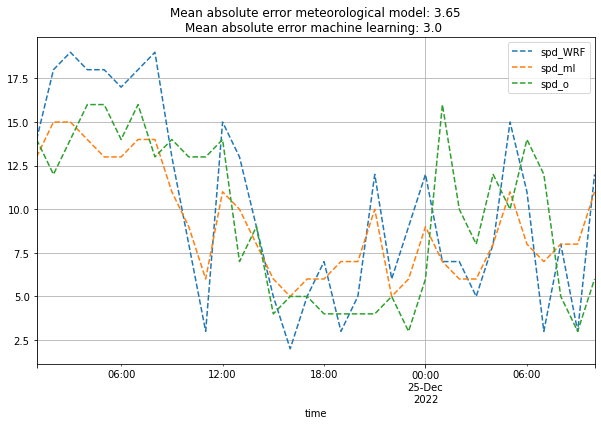

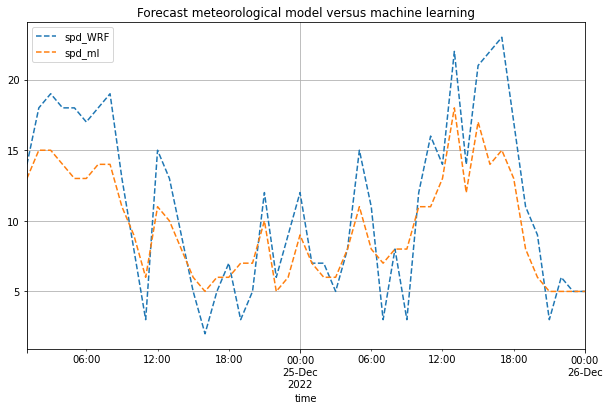

In [79]:
#@title Wind intensity
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#open algorithm spd d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/spd_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/spd_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat spd from ml
spd_ml = alg["pipe"].predict(meteo_model[:24][alg["x_var"]])
spd_ml1 = alg1["pipe"].predict(meteo_model[24:48][alg1["x_var"]])

df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "spd_WRF": np.concatenate((np.rint(model_x_var["mod0"]*1.94384),
                                                   np.rint(model_x_var1["mod0"]*1.94384)),axis=0),
                       "spd_ml": np.concatenate((np.rint(spd_ml*1.94384),
                                                  np.rint(spd_ml1*1.94384)),axis =0),})
df_for = df_for.set_index("time")

#metar versus forecast
# set the max columns to none
pd.set_option('display.max_rows', 100)

# concat metars an forecast
df_res = pd.concat([df_for,metars["spd_o"]],axis = 1)

#get mae
df_res_dropna = df_res.dropna()
mae_ml = round(mean_absolute_error(df_res_dropna.spd_o,df_res_dropna.spd_ml),2)
mae_wrf = round(mean_absolute_error(df_res_dropna.spd_o,df_res_dropna.spd_WRF),2)

#print results
print("***Wind intensity knots***")
print("Reference (48 hours) Mean absolute error meteorological model: 1.35")
print("Reference (48 hours) Mean absolute error machine learning: 0.89\n")

#print("\n",df_res[["spd_ml","spd_o","spd_WRF"]])
title = "Mean absolute error meteorological model: {}\nMean absolute error machine learning: {} ".format(mae_wrf,mae_ml)

#show results
df_res.dropna().plot(grid=True,figsize=(10,6),linestyle='--',title = title);
df_for.plot(grid=True,figsize=(10,6),linestyle='--', title = "Forecast meteorological model versus machine learning");

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


***Wind direction***
Reference (48 hours) Accuracy meteorological model: 0.20
Reference (48 hours) Accuracy machine learning: 0.41


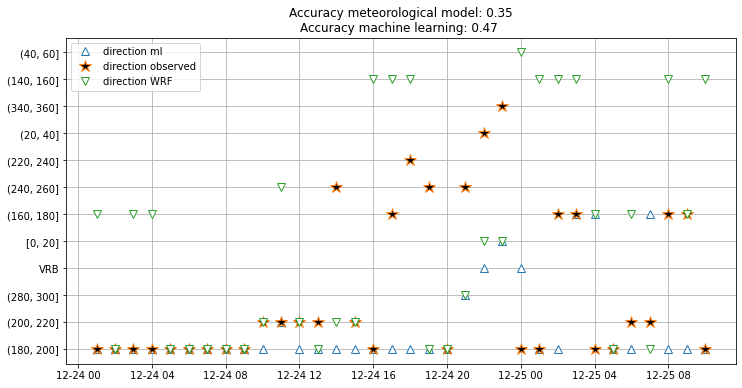

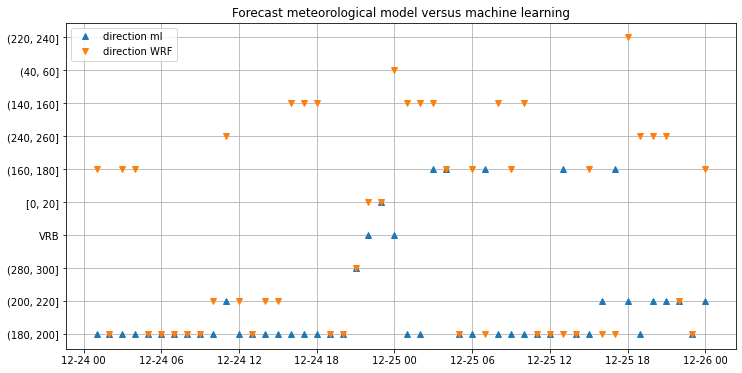

In [80]:
#@title wind direction
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#open algorithm spd d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/dir_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/dir_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat spd from ml
dir_ml = alg["pipe"].predict(model_x_var)
dir_ml1 = alg1["pipe"].predict(model_x_var1)

#set up dataframe forecast machine learning and WRF
df_for = pd.DataFrame({"time":meteo_model[:48].index,
                        "dir_WRF": np.concatenate((model_x_var["dir0"],model_x_var1["dir0"]),axis=0),
                        "dir_ml": np.concatenate((dir_ml,dir_ml1),axis =0),})
df_for = df_for.set_index("time")

#label dir_o and dir0 .wind direction to interval dir=-1 variable wind
interval = pd.IntervalIndex.from_tuples([(-1.5, -0.5),(-0.5,20), (20, 40), (40, 60),
                                           (60,80),(80,100),(100,120),(120,140),(140,160),
                                           (160,180),(180,200),(200,220),(220,240),
                                           (240,260),(260,280),(280,300),(300,320),
                                           (320,340),(340,360)])

labels = ['VRB', '[0, 20]', '(20, 40]', '(40, 60]','(60, 80]', '(80, 100]',
          '(100, 120]', '(120, 140]','(140, 160]', '(160, 180]', '(180, 200]',
          '(200, 220]','(220, 240]', '(240, 260]', '(260, 280]', '(280, 300]',
          '(300, 320]', '(320, 340]', '(340, 360]']

df_for["dir_WRF_l"] = pd.cut(df_for["dir_WRF"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)

#dir_o to intervals 
metars["dir_o_l"] = pd.cut(metars["dir_o"].replace("M",-1).astype(float), bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)                    

#metar versus forecast
# set the max columns to none
pd.set_option('display.max_rows', 100)

# concat metars an forecast
df_res = pd.concat([df_for,metars[["dir_o","dir_o_l"]]],axis = 1)

#get accuracy
df_res_dropna = df_res.dropna()
acc_ml = round(accuracy_score(df_res_dropna.dir_o_l,df_res_dropna.dir_ml),2)
acc_wrf = round(accuracy_score(df_res_dropna.dir_o_l,df_res_dropna.dir_WRF_l),2)

#print results
print("***Wind direction***")
print("Reference (48 hours) Accuracy meteorological model: 0.20")
print("Reference (48 hours) Accuracy machine learning: 0.41")
#print("\n",df_res[["dir_ml","dir_o_l","dir_WRF_l"]])

#show results
plt.figure(figsize=(12, 6))
plt.plot(df_res_dropna.index, df_res_dropna['dir_ml'], marker="^", markersize=8, 
         markerfacecolor='w', linestyle='')
plt.plot(df_res_dropna.index, df_res_dropna['dir_o_l'], marker="*", markersize=13,
         markerfacecolor='k', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['dir_WRF_l'], marker="v", markersize=8,
         markerfacecolor='w', linestyle='');
plt.legend(('direction ml', 'direction observed', 'direction WRF'),)
plt.grid(True)
plt.title("Accuracy meteorological model: {}\nAccuracy machine learning: {} ".format(acc_wrf,acc_ml))
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(df_for.index, df_for['dir_ml'],marker="^",linestyle='');
plt.plot(df_for.index, df_for['dir_WRF_l'],marker="v",linestyle='');
plt.legend(('direction ml','direction WRF'),)
plt.title("Forecast meteorological model versus machine learning")
plt.grid(True)
plt.show()

***Wind direction***
Reference (48 hours) Heidke skill Score: 0.42

Confusion matrix
gust_ml   Gust  No Gust  All
gust_o_l                    
Gust         1        1    2
No Gust      4       28   32
All          5       29   34


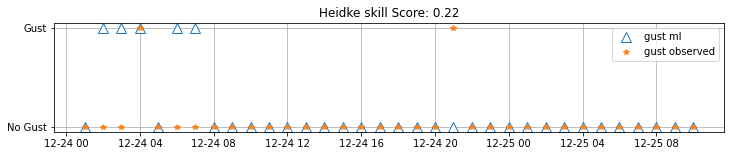

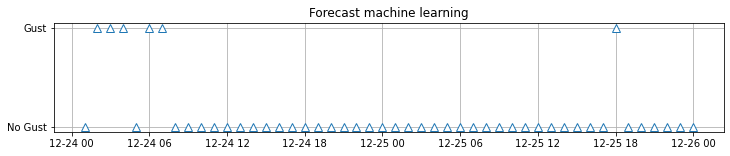

In [81]:
#@title Wind gust
#open algorithm gust d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/gust_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/gust_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat gust from ml
gust_ml = alg["pipe"].predict(model_x_var)
gust_ml1 = alg1["pipe"].predict(model_x_var1)

#label metars gust data
metars["gust_o_l"] = ["No Gust" if c=="M" else "Gust" for c in metars.gust_o]

#set up dataframe forecast machine learning 
df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "gust_ml": np.concatenate((gust_ml,gust_ml1),axis =0),})
df_for = df_for.set_index("time")

# concat metars an forecast
df_res = pd.concat([df_for,metars["gust_o_l"]], axis = 1)
df_res_dropna = df_res.dropna()

#Heidke skill score
cm = pd.crosstab(df_res.dropna().gust_o_l, df_res.dropna().gust_ml, margins=True,)
HSS = 0
if cm.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

#show results
print("***Wind direction***")
print("Reference (48 hours) Heidke skill Score: 0.42\n")
print("Confusion matrix")
print(cm)
#print(df_res)

plt.figure(figsize=(12, 2))
plt.plot(df_res_dropna.index, df_res_dropna['gust_ml'], marker="^", markersize=10, 
         markerfacecolor='w', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['gust_o_l'],marker="*",linestyle='');
plt.legend(('gust ml', 'gust observed'),)
plt.grid(True)
plt.title("Heidke skill Score: {}".format(HSS))
plt.show()


plt.figure(figsize=(12, 2))
plt.plot(df_for.index, df_for['gust_ml'],marker="^", markersize=8, markerfacecolor='w', linestyle='');
plt.title("Forecast machine learning")
plt.grid(True)
plt.show()

***Precipitation***
Reference (48 hours) Heidke skill score meteorological model: 0.43
Reference (48 hours) Heidke skill score machine learning: 0.55

Confusion matrix machine learning
prec_ml   No RA/DZ  RA/DZ  All
prec_o_l                      
No RA/DZ         0     16   16
RA/DZ            5     13   18
All              5     29   34

Confusion matrix meteorological model
prec_WRF  No RA/DZ  RA/DZ  All
prec_o_l                      
No RA/DZ         3     13   16
RA/DZ            2     16   18
All              5     29   34


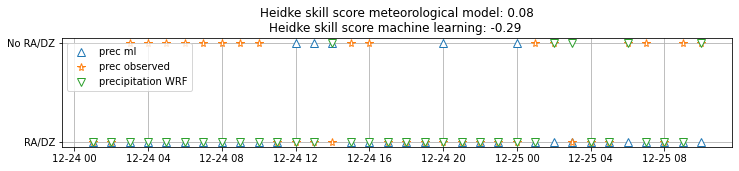

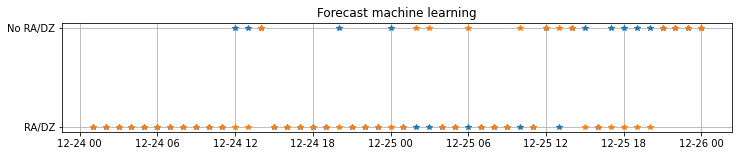

In [82]:
#@title Precipitation
#open algorithm prec d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/prec_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/prec_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat prec from ml
prec_ml = alg["pipe"].predict(model_x_var)
prec_ml1 = alg1["pipe"].predict(model_x_var1)

#label metars prec data
metars["prec_o_l"] = "No RA/DZ"
mask = metars['wxcodes_o'].str.contains("RA")
metars.loc[mask,["prec_o_l"]] = "RA/DZ"
mask = metars['wxcodes_o'].str.contains("DZ")
metars.loc[mask,["prec_l"]] = "RA/DZ"

#label meteorological model prec0
prec0_l= ["RA/DZ" if c>0 else "No RA/DZ" for c in np.concatenate((model_x_var["prec0"],model_x_var1["prec0"]), axis=0)]

#set up dataframe forecast machine learning 
df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "prec_WRF": prec0_l,
                       "prec_ml": np.concatenate((prec_ml,prec_ml1),axis =0),})
df_for = df_for.set_index("time")

# concat metars an forecast
df_res = pd.concat([df_for,metars["prec_o_l"]], axis = 1)
df_res_dropna = df_res.dropna()

#Heidke skill score ml
cm_ml = pd.crosstab(df_res.dropna().prec_o_l, df_res.dropna().prec_ml, margins=True,)
HSS_ml = 0
if cm_ml.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm_ml.values[0,0]
  b = cm_ml.values[1,0]
  c = cm_ml.values[0,1]
  d = cm_ml.values[1,1]
  HSS_ml = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

#Heidke skill score meteorological model
cm_wrf = pd.crosstab(df_res.dropna().prec_o_l, df_res.dropna().prec_WRF, margins=True,)
HSS_wrf = 0
if cm_wrf.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm_wrf.values[0,0]
  b = cm_wrf.values[1,0]
  c = cm_wrf.values[0,1]
  d = cm_wrf.values[1,1]
  HSS_wrf = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

#show results
print("***Precipitation***")
print("Reference (48 hours) Heidke skill score meteorological model: 0.43")
print("Reference (48 hours) Heidke skill score machine learning: 0.55\n")
print("Confusion matrix machine learning")
print(cm_ml)
print("\nConfusion matrix meteorological model")
print(cm_wrf)
#print(df_res)

plt.figure(figsize=(12, 2))
plt.plot(df_res_dropna.index, df_res_dropna['prec_ml'],marker="^", markersize=8, 
         markerfacecolor='w', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['prec_o_l'],marker="*",markersize=8, 
         markerfacecolor='w', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['prec_WRF'],marker="v",markersize=8, 
         markerfacecolor='w', linestyle='');
plt.legend(('prec ml', 'prec observed',"precipitation WRF"),)
plt.grid(True)
plt.title("Heidke skill score meteorological model: {}\nHeidke skill score machine learning: {} ".format(HSS_wrf,HSS_ml))
plt.show()


plt.figure(figsize=(12, 2))
plt.plot(df_for.index, df_for['prec_ml'],marker="*",linestyle='');
plt.plot(df_for.index, df_for['prec_WRF'],marker="*",linestyle='');
plt.title("Forecast machine learning")
plt.grid(True)
plt.show()

***BR or FG***
Reference (48 hours) Heidke skill score machine learning: 0.64

Confusion matrix machine learning
brfg_ml   BR/FG  No BR/FG  All
brfg_o_l                      
No BR/FG     21        13   34
All          21        13   34


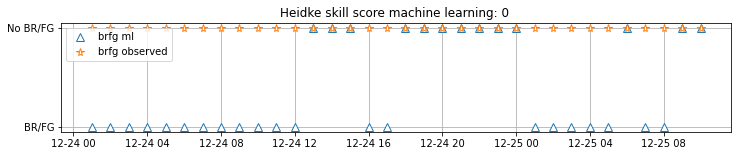

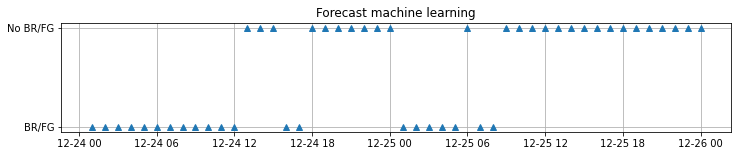

In [83]:
#@title BR or FG
#open algorithm prec d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/brfg_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/brfg_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat br/fg from ml
brfg_ml = alg["pipe"].predict(model_x_var)
brfg_ml1 = alg1["pipe"].predict(model_x_var1)

#label metars br/fg data
metars["brfg_o_l"] = "No BR/FG"
mask = metars['wxcodes_o'].str.contains("BR")
metars.loc[mask,["brfg_o_l"]] = "BR/FG"
mask = metars['wxcodes_o'].str.contains("FG")
metars.loc[mask,["prec_l"]] = "BR/FG"



#set up dataframe forecast machine learning 
df_for = pd.DataFrame({"time": meteo_model[:48].index,
                       "brfg_ml": np.concatenate((brfg_ml,brfg_ml1),axis =0),})
df_for = df_for.set_index("time")

# concat metars an forecast
df_res = pd.concat([df_for,metars["brfg_o_l"]], axis = 1)
df_res_dropna = df_res.dropna()

#Heidke skill score ml
cm_ml = pd.crosstab(df_res.dropna().brfg_o_l, df_res.dropna().brfg_ml, margins=True,)
HSS_ml = 0
if cm_ml.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm_ml.values[0,0]
  b = cm_ml.values[1,0]
  c = cm_ml.values[0,1]
  d = cm_ml.values[1,1]
  HSS_ml = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)


#show results
print("***BR or FG***")
print("Reference (48 hours) Heidke skill score machine learning: 0.64\n")
print("Confusion matrix machine learning")
print(cm_ml)


plt.figure(figsize=(12, 2))
plt.plot(df_res_dropna.index, df_res_dropna['brfg_ml'],marker="^", markersize=8, 
         markerfacecolor='w', linestyle='');
plt.plot(df_res_dropna.index, df_res_dropna['brfg_o_l'],marker="*",markersize=8, 
         markerfacecolor='w', linestyle='');
plt.legend(('brfg ml', 'brfg observed'),)
plt.grid(True)
plt.title("Heidke skill score machine learning: {} ".format(HSS_ml))
plt.show()


plt.figure(figsize=(12, 2))
plt.plot(df_for.index, df_for['brfg_ml'],marker="^",linestyle='');
plt.title("Forecast machine learning")
plt.grid(True)
plt.show()

***Temperature Celsius***
Reference (48 hours) Mean absolute error meteorological model: 1.44
Reference (48 hours) Mean absolute error machine learning: 0.85



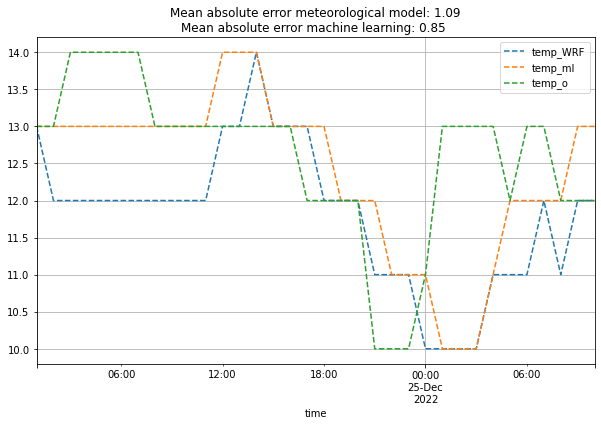

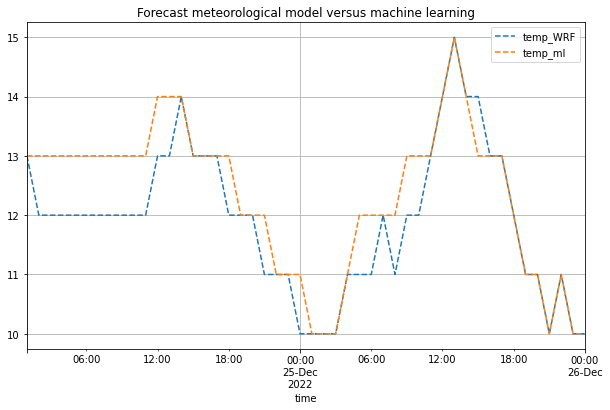

In [84]:
#@title Temperature
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#open algorithm spd d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/temp_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/temp_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat spd from ml
temp_ml = alg["pipe"].predict(meteo_model[:24][alg["x_var"]])
temp_ml1 = alg1["pipe"].predict(meteo_model[24:48][alg1["x_var"]])

df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "temp_WRF": np.concatenate((np.rint(model_x_var["temp0"]-273.16),
                                                   np.rint(model_x_var1["temp0"]-273.16)),axis=0),
                       "temp_ml": np.concatenate((np.rint(temp_ml-273.16),np.rint(temp_ml1-273.16)),axis =0),})
df_for = df_for.set_index("time")

#metar versus forecast
# set the max columns to none
pd.set_option('display.max_rows', 100)

# concat metars an forecast
df_res = pd.concat([df_for,metars["temp_o"]],axis = 1)

#get mae
df_res_dropna = df_res.dropna()
mae_ml = round(mean_absolute_error(df_res_dropna.temp_o,df_res_dropna.temp_ml),2)
mae_wrf = round(mean_absolute_error(df_res_dropna.temp_o,df_res_dropna.temp_WRF),2)

#print results
print("***Temperature Celsius***")
print("Reference (48 hours) Mean absolute error meteorological model: 1.44")
print("Reference (48 hours) Mean absolute error machine learning: 0.85\n")

#print("\n",df_res[["spd_ml","spd_o","spd_WRF"]])
title = "Mean absolute error meteorological model: {}\nMean absolute error machine learning: {} ".format(mae_wrf,mae_ml)

#show results
df_res.dropna().plot(grid=True,figsize=(10,6),linestyle='--',title = title);
df_for.plot(grid=True,figsize=(10,6),linestyle='--', title = "Forecast meteorological model versus machine learning");